# Summary of work

This notebook contains minimal working examples for a few methods of supervised UMAP clustering. Please note that these results are not meant to be exhaustive, methods that appear to perform poorly may yet yield surprising results with different parameters. The methods outlined in this notebook are: supervised UMAP, semi-supervised UMAP, and tree-based UMAP using ExtraTrees. To illustrate 

# Load libraries, functions, and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold

mcc = make_scorer(matthews_corrcoef)
encoder = LabelEncoder()


def colour_dict(var_column, blackout_list=[]):
    # Creates a colour dictionary with 20 distinct colours. Blackout_list offers the possibility to directly assign the colour black to groups.  
    # If the number of groups in the variable column exceeds 20, the only largest groups will be given the distinct colours.
    # If the number of groups is smaller than 20, the first n colours will be used.
    # Colours by Sasha Trubetskoy at https://sashamaps.net/docs/resources/20-colors/
    
    colours = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#0000CD', '#800000', # replaced FFFAC8 (beige) with #0000CD (medium blue) for better visibility against light background
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080']
    groups = list(var_column.value_counts(ascending=False).index)
    for elem in blackout_list:
        groups.remove(elem)
    while (len(groups) > len(colours)):
           colours.append("#000000")
    colour_dict = dict(zip(groups, colours))
    for elem in blackout_list:
        colour_dict[elem] = "#000000"
    return colour_dict


def undersample_classes(spectrum_metadata, var, min_class_size, sample_size, random_state = 42):
    # Pass spectrum_metadata dataframe to function, and it will return a downsampled selection for you, from classes that satisfy the specified minimum class size
    # Multiclass spectra are automatically detected and ignored
    # If sample_size input is an integer, this will be the sample size.
    # If sample_size == "all" or any other non-integer, all spectra from the classes that satisfy the minimum class size will be be returned
    
    class_counts = spectrum_metadata[var].value_counts()
    class_counts = class_counts[class_counts>=min_class_size]
    selected_classes = class_counts[[';' not in s for s in class_counts.index]] # Discard multiclass labels
    selection = spectrum_metadata[spectrum_metadata[var].isin(selected_classes.index)]
    
    if (isinstance(sample_size, int)):
        class_dict = dict(selected_classes)
        class_dict = dict.fromkeys(class_dict, sample_size)
        resampler = RandomUnderSampler(sampling_strategy = class_dict, random_state = random_state)
        downsampled_selection = resampler.fit_resample(selection, selection[var])[0]
        metadata_indices = selection.iloc[resampler.sample_indices_].index # Get original indices by taking the sampled rows from the selection dataframe
        downsampled_selection.set_index(metadata_indices, inplace = True)  # Restore original indices
        return downsampled_selection
    return selection

In [2]:
data_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Data/"
model_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Model/"
embedding_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Embeddings/"
plot_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Plots/"

# Load metadata of inchikey-annotated spectra
spectrum_metadata = pd.read_csv(data_dir+"GNPS_210409 Metadata inchi annotated spectra.csv", sep = "\t")

# Load MS2DS vectors
all_ms2ds = pd.read_pickle(embedding_dir+"MS2DeepScore_embedding_annotated_spectra_210409_joblib.pickle")

# Select only MS2DS vectors of annotated spectra, transform to dataframe
annotated_ms2ds = [all_ms2ds[i] for i in spectrum_metadata["spectrum_index"]]
ms2ds = pd.DataFrame(np.vstack(annotated_ms2ds))

len(ms2ds) == len(spectrum_metadata)

True

# Supervised UMAP

There are two flavors of supervised UMAP: fully supervised UMAP, with a seperate testing and training set, and semi-supervised UMAP, which uses partial labelling and embeds all data at once. The most important variable to solve under- or overfitting is target_weight, which is described in the man page. It is the weighting factor between data topology and target topology. A value of 0.0 weights entirely on data, while a value of 1.0 weights entirely on target. The default of 0.5 balances the weighting equally between data and target.
 
See https://umap-learn.readthedocs.io/en/latest/supervised.html for more information on (semi-)supervised UMAP. Note that supervised UMAP only works with classes encoded as integers. For this purpose I use sklearn's LabelEncoder, which I recommend. 

## Option 1: seperate testing and training set

In [5]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.01, stratify = y)
y_train_encoded = encoder.fit_transform(y_train)

In [15]:
len(X_test)

1734

In [6]:
%time fit_model = umap.UMAP(n_components = 2, n_neighbors = 100, metric = "cosine").fit(X_train, y_train_encoded)

Wall time: 4min 46s


In [7]:
%time test_embedding = fit_model.transform(X_test)

Wall time: 35.2 s


In [8]:
train_df = pd.DataFrame(fit_model.embedding_, index = y_train, columns = ["x", "y"])
test_df = pd.DataFrame(test_embedding, index = y_test, columns = ["x", "y"])

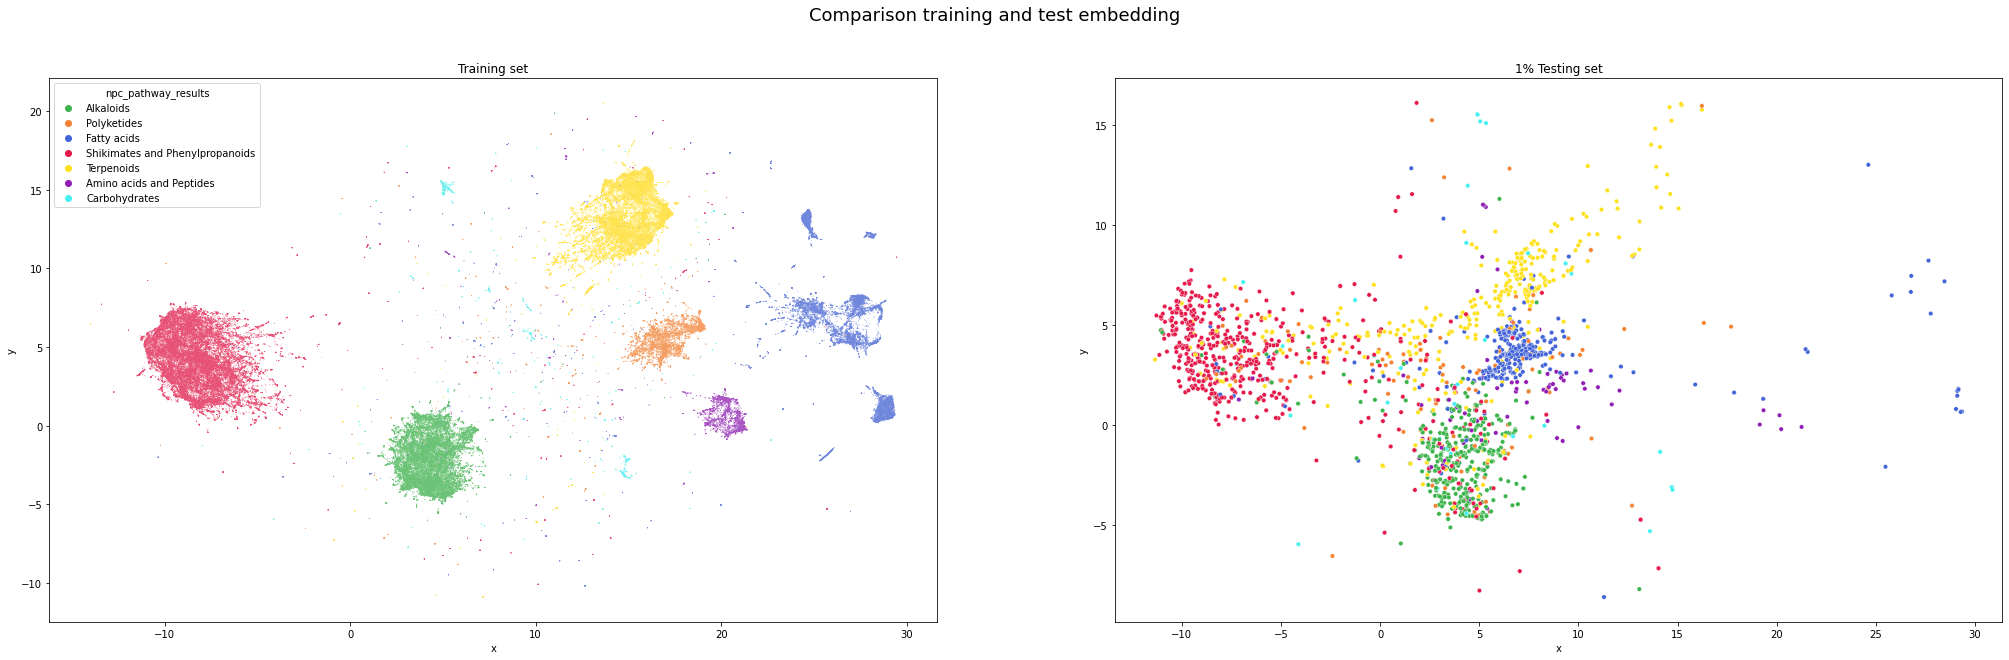

In [16]:
palette = colour_dict(y)

fig, axes = plt.subplots(1, 2, figsize=(35,10))
fig.suptitle("Comparison training and test embedding", fontsize = 18)
titles = ["Training set", "1% Testing set"]

sns.scatterplot(x = train_df["x"], y = train_df["y"], hue = train_df.index, s = 0.5, legend = True, palette = palette, ax = axes[0])
sns.scatterplot(x = test_df["x"], y = test_df["y"], hue = test_df.index, s = 10, legend = False, palette = palette, ax = axes[1])

for ax, title in zip(axes, titles):
    ax.set_title(title)

## Option 2: using partial labelling

In [26]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.01, stratify = y)
y_train_encoded = encoder.fit_transform(y_train)

In [29]:
# Mask test set
data = np.vstack([X_train, X_test])
masked_y = np.hstack([y_train_encoded, len(y_test)*[-1]])
true_y = np.hstack([y_train, y_test])

In [30]:
# Embed with UMAP
semi_supervised_umap = umap.UMAP(n_components = 2, n_neighbors = 100, metric = "cosine").fit(data, masked_y)

In [31]:
semi_supervised_df = pd.DataFrame(semi_supervised_umap.embedding_, index = true_y, columns = ["x", "y"])

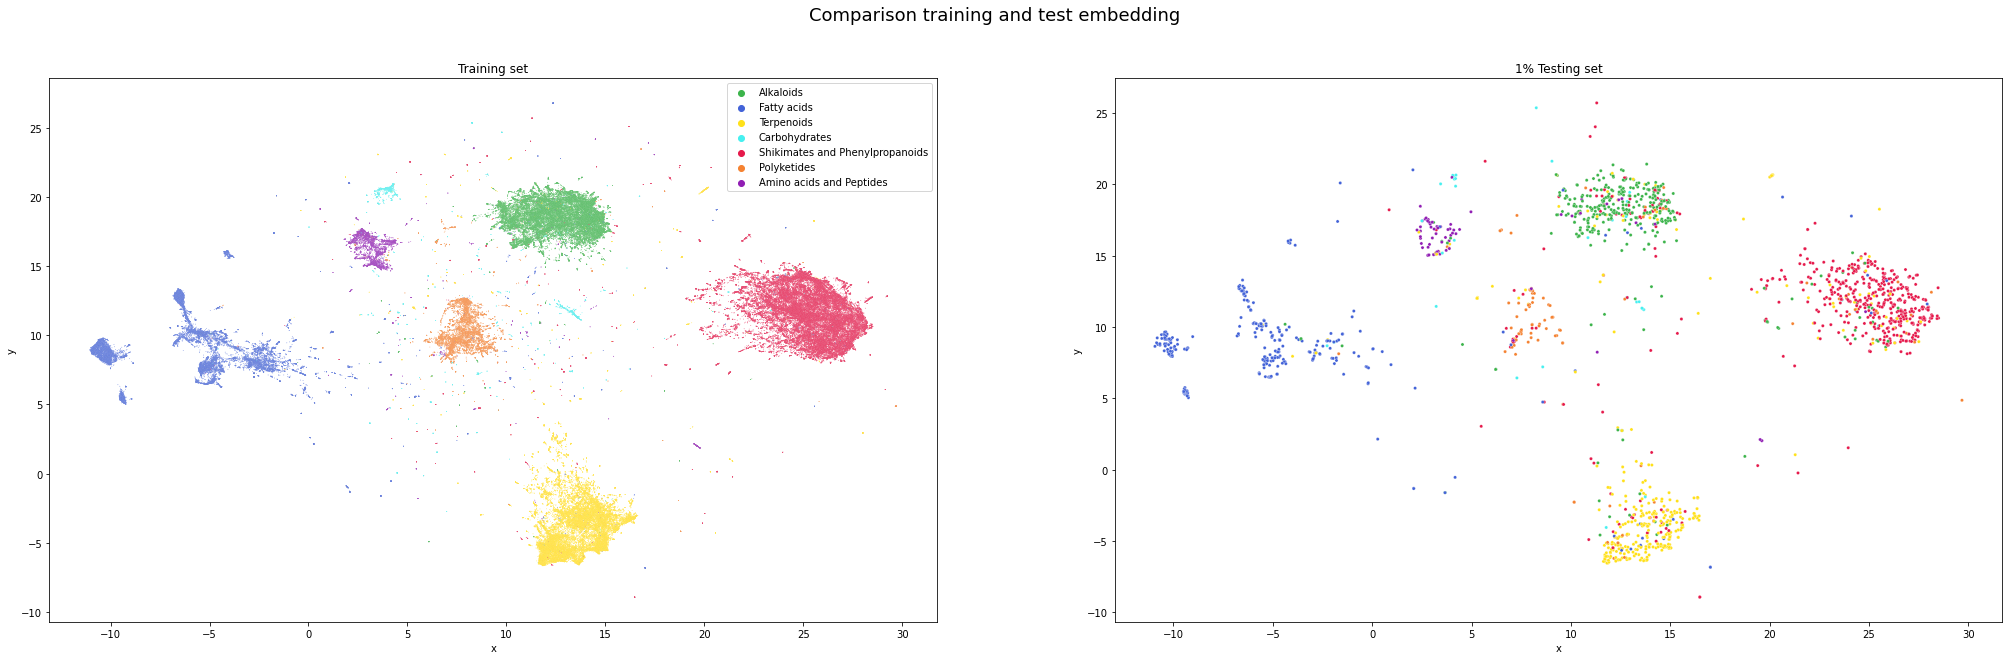

In [37]:
train_df = semi_supervised_df[:len(X_train)]
test_df = semi_supervised_df[len(X_train):]

palette = colour_dict(y)

fig, axes = plt.subplots(1, 2, figsize=(35,10))
fig.suptitle("Comparison training and test embedding", fontsize = 18)
titles = ["Training set", "1% Testing set"]

sns.scatterplot(x = train_df["x"], y = train_df["y"], hue = train_df.index, s = 0.5, legend = True, palette = palette, ax = axes[0])
sns.scatterplot(x = test_df["x"], y = test_df["y"], hue = test_df.index, s = 10, legend = False, palette = palette, ax = axes[1])

for ax, title in zip(axes, titles):
    ax.set_title(title)

# Tree-based supervision

Here I use only ExtraTrees, but this idea also works with other tree-based approaches such as Decision Tree Classifiers or Random Forests. The method is based on this blogpost (https://gdmarmerola.github.io/forest-embeddings/) by Guilherme Duarte Marmerola. I would also recommend reviewing his Jupyter notebook here: https://github.com/gdmarmerola/forest-embeddings/blob/master/umap_and_supervised_embeddings.ipynb.

Do not presume that because models seem similar, or achieve similar classification success, that they will produce similar UMAP embeddings. Because the distance matrix produced by the model is based on co-occurence in terminal leaf nodes, max_leaf_nodes might be useful in solving under- and overfit issues. Setting max_leaf_nodes to 200, however, resulted in a pretty massive dent in the model's performance. To show how different embeddings can look, UMAPS of the best and worst performing ExtraTrees models are shown.

## Parameter comparison

In [9]:
# Varying two promising features
et_simple = ExtraTreesClassifier(n_estimators=1000, max_features = None, max_leaf_nodes = None, class_weight='balanced', n_jobs=2)
et_maxleaf = ExtraTreesClassifier(n_estimators=1000, max_features = None, max_leaf_nodes = 200, class_weight='balanced', n_jobs=2)
et_maxfeat = ExtraTreesClassifier(n_estimators=1000, max_features = 1, max_leaf_nodes = None, class_weight='balanced', n_jobs=2)
et_combined = ExtraTreesClassifier(n_estimators=1000, max_features = 1, max_leaf_nodes = 200, class_weight='balanced', n_jobs=2)

In [7]:
# Select data
var = "npc_pathway_results"
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
x = ms2ds.iloc[selection.index]
y = selection[var]

In [ ]:
%%time

#Compare models
scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True)

for model in [et_simple, et_maxleaf, et_maxfeat, et_combined]:
    print("Started model evaluation")
    %time scores += [cross_val_score(model, X = x, y = y, cv = skf, scoring = mcc)]

Started model evaluation
Wall time: 22h 28min 17s
Started model evaluation


In [12]:
print([np.median(score) for score in scores])

[0.7721646068029395, 0.5390724738227449, 0.7594057745727825, 0.5231141705405526]


## Transform to UMAP

In [14]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.01, stratify = y)

In [15]:
%%time 
model = et_simple
et_umap = umap.UMAP(n_neighbors = 100, metric='hamming')

# Training step
model.fit(X_train, y_train); print("Finished fitting model")
train_leaves = model.apply(X_train)
et_train = et_umap.fit_transform(train_leaves); print("Finished fitting UMAP")

# Testing step
test_leaves = model.apply(X_test)
et_test = et_umap.transform(test_leaves)

Finished fitting model


C:\Users\Artur\anaconda3\envs\plotly\lib\site-packages\umap\umap_.py:1762: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Finished fitting UMAP
Wall time: 49min 38s


In [16]:
et_train_df = pd.DataFrame(et_train, index = y_train, columns = ["x", "y"])
et_test_df = pd.DataFrame(et_test, index = y_test, columns = ["x", "y"])

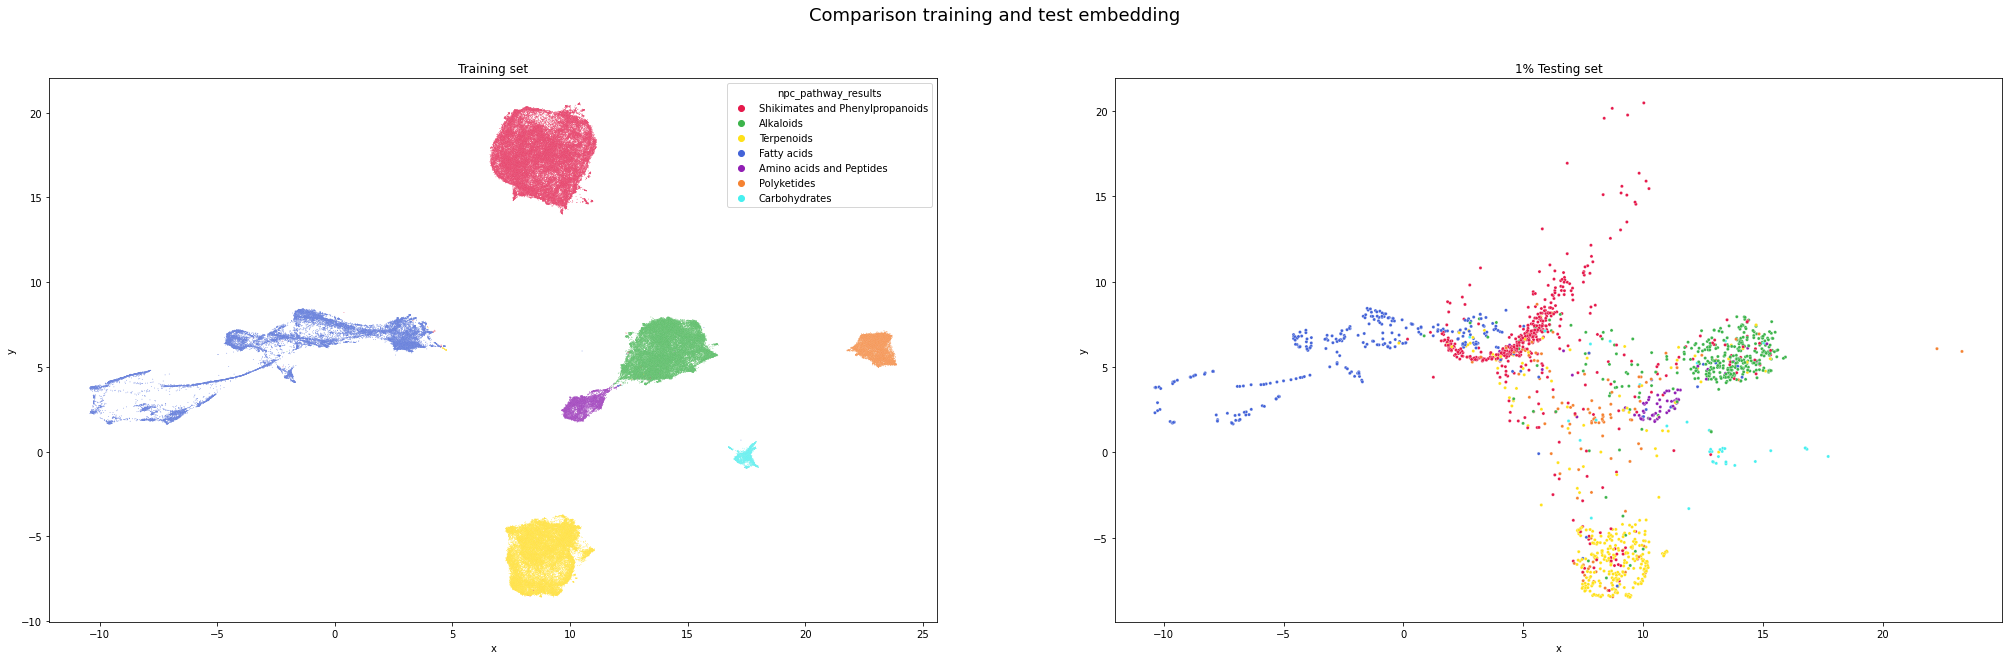

In [17]:
# UMAP based on et_simple model, MCC 0.77

palette = colour_dict(y)

train_df = et_train_df
test_df = et_test_df

fig, axes = plt.subplots(1, 2, figsize=(35,10))
fig.suptitle("Comparison training and test embedding", fontsize = 18)
titles = ["Training set", "1% Testing set"]

sns.scatterplot(x = train_df["x"], y = train_df["y"], hue = train_df.index, s = 0.5, legend = True, palette = palette, ax = axes[0])
sns.scatterplot(x = test_df["x"], y = test_df["y"], hue = test_df.index, s = 10, legend = False, palette = palette, ax = axes[1])

for ax, title in zip(axes, titles):
    ax.set_title(title)

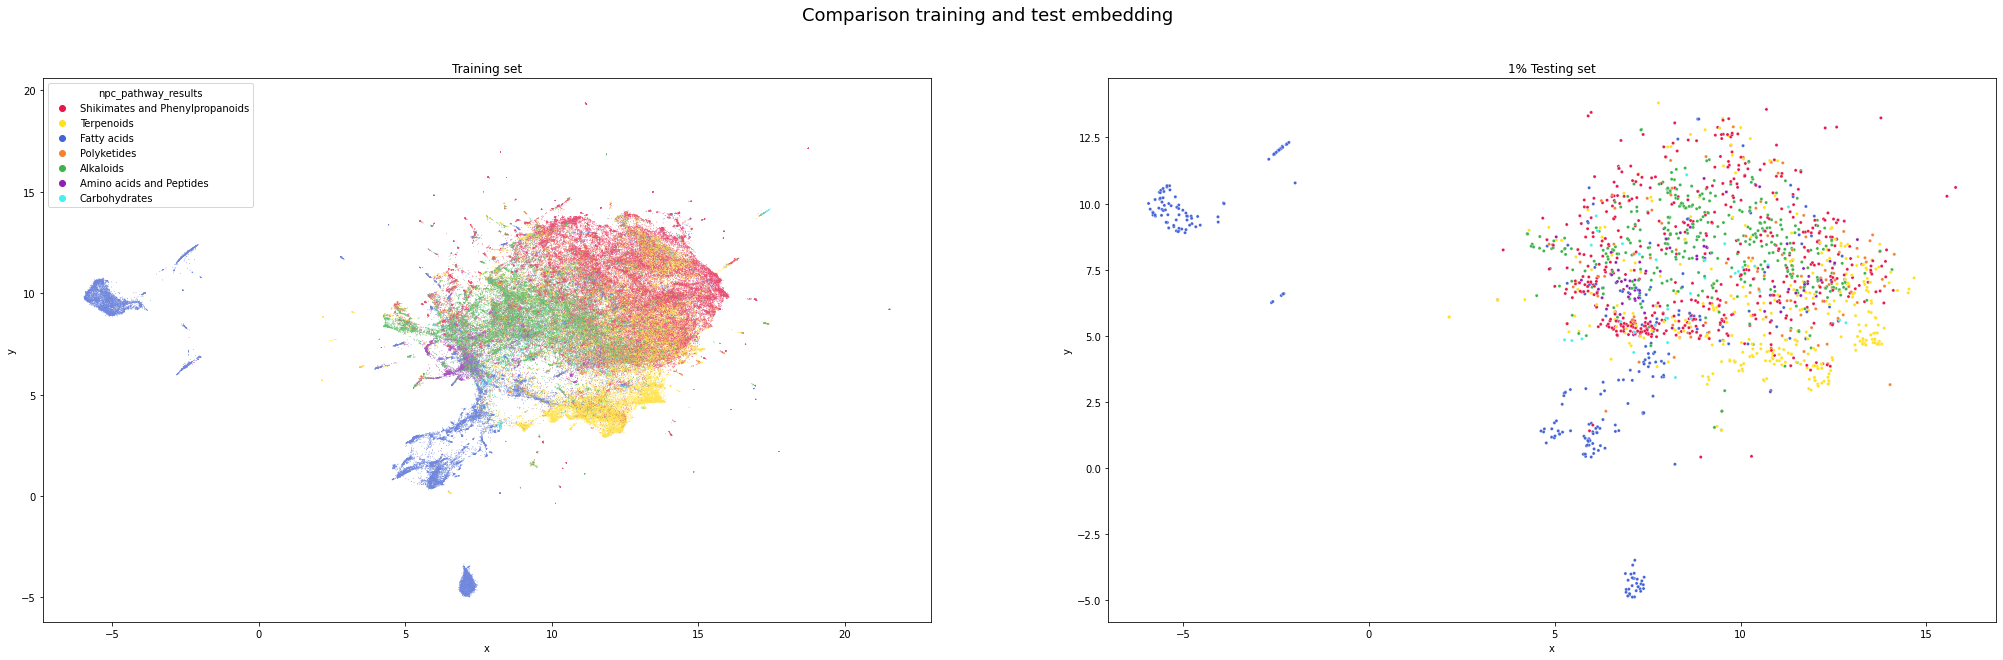

In [56]:
#UMAP based on et_combined model, MCC 0.52

palette = colour_dict(y)

train_df = et_train_df
test_df = et_test_df

fig, axes = plt.subplots(1, 2, figsize=(35,10))
fig.suptitle("Comparison training and test embedding", fontsize = 18)
titles = ["Training set", "1% Testing set"]

sns.scatterplot(x = train_df["x"], y = train_df["y"], hue = train_df.index, s = 0.5, legend = True, palette = palette, ax = axes[0])
sns.scatterplot(x = test_df["x"], y = test_df["y"], hue = test_df.index, s = 10, legend = False, palette = palette, ax = axes[1])

for ax, title in zip(axes, titles):
    ax.set_title(title)